In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import animation
import pandas as pd
import scipy.stats as stats

In [3]:
### 1. sample from MCMC with Metropolis Hastings
###     Underlying distribution: AA only depends on previous position. Probability matrix of alphabets based on war_and_peace.txt
### 2. Create a2m files from the samples
### 3. Train a potts model with plmc
### 4. Observe dependency matrices

1. Sampling Sequences with MCMC

In [16]:
### first learn the conditional probabilities
input_file = "war_and_peace.txt"

def build_bigram_freq_matrix(input_file):
    """
    Builds a matrix that represents the transitional
    probabilities between letters in input_file.
    
    bigram_freq_matrix[0][1] is the probability of
    transitioning from the 0th letter of the alphabet
    to the 1st letter of the alphabet, where letters
    are zero-indexed. ' ' (space) is denoted as the
    26th letter of the alphabet.
    """
    counts = np.ones([27, 27])
    with open(input_file, 'r', encoding='utf8') as f:
        for _ in range(100000):
            line = f.readline()
            if len(line) > 2:
                for i in range(len(line) - 2):
                    first_char = ord(line[i].upper()) - 65 if line[i].isalpha() else 26
                    second_char = ord(line[i+1].upper()) - 65 if line[i+1].isalpha() else 26
                    if not (first_char == 26 and second_char == 26) and first_char <= 26 and second_char <= 26:
                        counts[first_char][second_char] += 1
        bigram_freq_matrix = (counts.T / np.sum(counts, axis=1)).T
    return bigram_freq_matrix

freq_matrix = build_bigram_freq_matrix(input_file)

### freq_matrix is based on all 26 letters of the english alphabet + space
### map the matrix to protein alphabets
ALPHABET_PROTEIN = '-ACDEFGHIKLMNPQRSTVWY'
indices = []
for aa in list(ALPHABET_PROTEIN):
    if aa == '-':
        indices.append(26)
    else:
        indices.append(ord(aa)-ord('A'))


In [27]:
protein_freq_matrix = freq_matrix[indices]
protein_freq_matrix = protein_freq_matrix[:, indices]

In [28]:
protein_freq_matrix.shape

(21, 21)

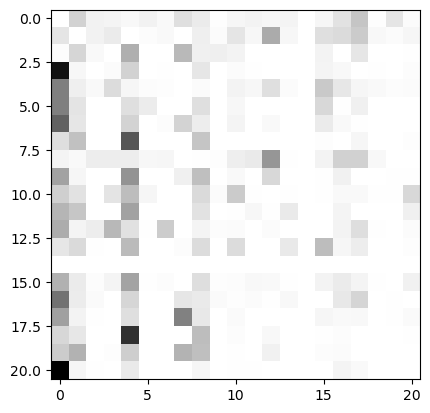

In [29]:
plt.imshow(protein_freq_matrix, cmap='binary', interpolation='none')    

In [30]:
def metropolis_hastings(proposal_func, init_func, score_func,
                        num_iters, step=30):
    result = []
    cur = init_func()
    new_state = True
    for i in range(num_iters):
        candidate = proposal_func(cur)
        score = score_func(cur, candidate)
        if score >= 1:
            cur = candidate
        else:
            r = np.random.rand()
            if r <= score:
                cur = candidate
                new_state = True
        if (i%step == 0 and new_state):
            result.append(cur)
            new_state = False
    return result

In [ ]:
SEQ_LEN = 15
## initialize random starting state
np.random.permutation